In [1]:
import cv2
import numpy as np
import os
import pandas as pd

# Generate Hairy or Not labels for HAM10K

Going to generate labels based on the binary classification using classical CV of the HAM10K dataset before feeding it through the autoencoder.
This uses code from "git" that uses implements the DullRazor algorithm to determine how much of the image is covered in hair. Per the authors of the paper, I will use 3000 train images, 100 validation, and 100 hair free images for finetuning.

In [2]:
df = pd.read_csv("HAM10K/HAM10000_metadata.csv")

In [46]:
def calculate_hair_density(image_path):
    TARGET_SIZE = (256, 256)
    KERNEL = (7,7)
    """
    Applies Black-Hat transform to detect hair and returns 
    the percentage of the image covered by hair (0.0 to 1.0).
    """
    img = cv2.imread(image_path)
    if img is None:
        return None  # Handle corrupt images gracefully
    
    img = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Kernel for Black-Hat transform (detects dark features on light background)
    # 17x17 is a good balance for typical dermoscopy hair thickness
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, KERNEL)
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    
    # Threshold to create binary mask (10 is intensity threshold)
    _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    
    # Calculate density
    hair_pixels = np.count_nonzero(mask)
    total_pixels = mask.size
    
    return hair_pixels / total_pixels
    

In [47]:
scores = []
paths = []

In [48]:
def add_hair_labels(df: pd.DataFrame):
    for _, row in df.iterrows():
        image_path = os.path.join("HAM10K", "images", f"{row['image_id']}.jpg")

        score = calculate_hair_density(image_path)
    
        if score is None:
            continue # Skip corrupt files
        
        # compute the scores
        paths.append(image_path)
        scores.append(score)


In [50]:
add_hair_labels(df)

In [51]:
df['hair_score'] = pd.Series(scores)
df['image_paths'] = pd.Series(paths)

In [52]:
from PIL import Image
import matplotlib.pyplot as plt

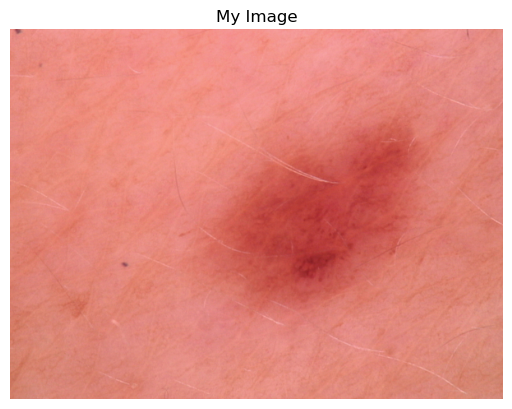

In [79]:
p = "HAM10K/images/ISIC_0029024.jpg"
img = Image.open(p)
plt.imshow(img)
plt.axis('off')  # Optional: turn off axis ticks and labels
plt.title("My Image") # Optional: add a title
plt.show()

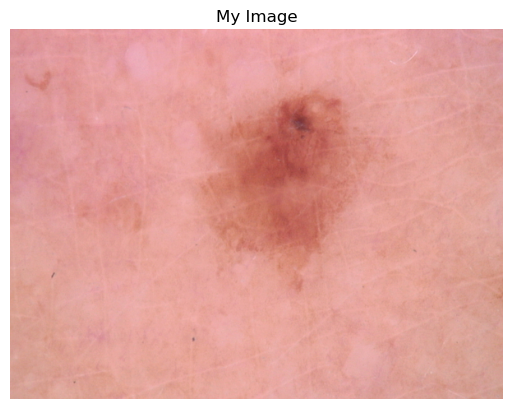

In [81]:
p = "HAM10K/images/ISIC_0028387.jpg"
img = Image.open(p)
plt.imshow(img)
plt.axis('off')  # Optional: turn off axis ticks and labels
plt.title("My Image") # Optional: add a title
plt.show()

In [162]:
df = df.rename(columns={"image_id":"ISIC_id"})

In [163]:
label_mapping = {
    'mel': 1,   # Cancerous
    'bcc': 1,   # Cancerous
    'akiec': 1, # Cancerous
    'nv': 0,    # Benign
    'bkl': 0,   # Benign
    'df': 0,    # Benign
    'vasc': 0   # Benign
}

In [164]:
df['target'] = df['dx'].map(label_mapping)

In [165]:
hairy = df.loc[df['hair_score'] >= 0.015].sort_values(by='hair_score', ascending=False)

In [166]:
training_examples = hairy.iloc[0:3000]
validation_examples = hairy.iloc[3000:3100]

Parition the hairy into train and validation labels by taking random samples, must ensure that the sets are disjoint, don't want any leakage.

In [167]:
clean = df.loc[df['hair_score'] < 0.015].sort_values(by='hair_score', ascending=True)

In [168]:
finetuning_examples = clean.iloc[0:1000]

In [169]:
finetuning_examples

,lesion_id,ISIC_id,dx,dx_type,age,sex,localization,hair_label,image_path,hair_score,image_paths,target
4725,HAM_0007582,ISIC_0027092,nv,follow_up,50.0,male,lower extremity,NaN,NaN,0.000290,HAM10K/images/ISIC_0027092.jpg,0
3856,HAM_0006579,ISIC_0030668,nv,follow_up,40.0,female,foot,NaN,NaN,0.000595,HAM10K/images/ISIC_0030668.jpg,0
6442,HAM_0000333,ISIC_0029098,nv,follow_up,40.0,male,hand,NaN,NaN,0.000671,HAM10K/images/ISIC_0029098.jpg,0
6034,HAM_0006589,ISIC_0031187,nv,follow_up,40.0,male,trunk,NaN,NaN,0.000977,HAM10K/images/ISIC_0031187.jpg,0
902,HAM_0004543,ISIC_0032170,bkl,consensus,0.0,female,back,NaN,NaN,0.001053,HAM10K/images/ISIC_0032170.jpg,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4952,HAM_0002373,ISIC_0030703,nv,follow_up,40.0,male,back,NaN,NaN,0.011292,HAM10K/images/ISIC_0030703.jpg,0
7186,HAM_0005300,ISIC_0033625,nv,histo,35.0,female,lower extremity,NaN,NaN,0.011292,HAM10K/images/ISIC_0033625.jpg,0
7935,HAM_0002329,ISIC_0034272,nv,histo,45.0,female,lower extremity,NaN,NaN,0.011292,HAM10K/images/ISIC_0034272.jpg,0
6477,HAM_0000828,ISIC_0024797,nv,follow_up,35.0,male,back,NaN,NaN,0.011307,HAM10K/images/ISIC_0024797.jpg,0


Dump the labels to json

In [170]:
finetuning_example = finetuning_examples[['ISIC_id', 'image_paths', 'hair_score', 'target']].to_dict(orient='records')

In [171]:
training_examples = training_examples[['ISIC_id', 'image_paths', 'hair_score', 'target']].to_dict(orient='records')
validation_examples = validation_examples[['ISIC_id','image_paths', 'hair_score', 'target']].to_dict(orient='records')

In [172]:
dump = {"finetuning_set":finetuning_example,
        "training_set":training_examples,
        "validation_set":validation_examples
        }

In [173]:
import json

In [174]:
with open("splits.json", "w") as f:
    json.dump(dump, f, indent=4)